In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import random
from itertools import combinations
import plotly.express as px
import ast
import pm4py
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

we consider a dataset documenting the Ski Resorts in Europe (**ski_resorts.csv**).
Each row contains some information about the Ski resort.
we can find a short description for each column:

| Column | Description |
| ------ | ----------- |
| Resort | The name of the ski & snowboard resort. |
| Country | The country in which the resort is located. |
| HighestPoint | The highest mountain point at the ski resort.   |
| LowestPoint | The lowest possible point to ski at the ski resort.  |
| DayPassPriceAdult | The price shows what it costs for 1 adult for 1 day in the main season in Euro. |
| BeginnerSlope | The total amount of “beginner” slopes in kilometer at the resort. “Beginner slopes” contains “children”, “blue” and, “green” slopes. |
| IntermediateSlope | The total amount of “intermediate” slopes in kilometer at the resort. “Intermediate slopes” contains “red” slopes. |
| DifficultSlope | The total amount of “difficult” slopes in kilometer at the resort. “Difficult slopes” contains “black”, “advanced”, and ”expert” slopes. |
| TotalSlope | The sum of “beginner slopes” + “intermediate slopes” + “difficult slopes” |
| Snowparks | Does the resort have one or more snowparks, or not? |
| NightSki | Does the resort offer skiing on illuminated slopes? |
| SurfaceLifts | The amount of lifts in this category: T-bar, Sunkidslift, Rope lifts, and people mower. |
| ChairLifts | The total amount of chairlifts. |
| GondolaLifts | The amount of lifts in this category: Gondola, Train lifts, Funicular, Combined gondola and chairlifts, Helicopter lifts, Snowcats, and Aerial tramways. |
| TotalLifts | The sum of “surface lifts etc” + “gondola etc” + “chairlifts etc.” |
| LiftCapacity | How many passengers can the lift system at the ski resort mowe in one hour? |
| SnowCannons  |The total amount of snow cannons at the ski resort.|

In [2]:
df = pd.read_csv('datasets/ski_resorts.csv', index_col=0)
duplicate_entries = df.index.duplicated(keep='first')

In [3]:
if duplicate_entries.any():
    print("Total Duplicates found: ", duplicate_entries.sum())
    df = df[~duplicate_entries]
    print("The Duplicate entries have been dropped")
else:
    print("There are no duplicate entries the dataset")

There are no duplicate entries the dataset


In [4]:
display(df.dtypes)
display(df.head(5))

Resort                object
Country               object
HighestPoint         float64
LowestPoint          float64
DayPassPriceAdult    float64
BeginnerSlope        float64
IntermediateSlope      int64
DifficultSlope       float64
TotalSlope             int64
Snowparks             object
NightSki              object
SurfaceLifts         float64
ChairLifts             int64
GondolaLifts         float64
TotalLifts             int64
LiftCapacity         float64
SnowCannons          float64
dtype: object

,Resort,Country,HighestPoint,LowestPoint,DayPassPriceAdult,BeginnerSlope,IntermediateSlope,DifficultSlope,TotalSlope,Snowparks,NightSki,SurfaceLifts,ChairLifts,GondolaLifts,TotalLifts,LiftCapacity,SnowCannons
1,Alpendorf (Ski amedé),Austria,1980.0,740.0,52.0,30.0,81,4.0,115,Yes,No,22.0,16,11.0,49,75398.0,600.0
2,Soldeu-Pas de la Casa/​Grau Roig/​El Tarter/​C...,Andorra,2640.0,1710.0,47.0,100.0,77,33.0,210,Yes,Yes,37.0,28,7.0,72,99017.0,1032.0
3,Oberau (Wildschönau),Austria,1130.0,900.0,30.0,1.0,0,1.0,2,No,No,2.0,0,0.0,2,1932.0,0.0
4,Dachstein West,Austria,1620.0,780.0,42.0,15.0,33,3.0,51,Yes,Yes,25.0,8,3.0,36,32938.0,163.0
5,Rosa Khutor,Southern Russia,2320.0,940.0,22.0,30.0,26,21.0,77,Yes,No,6.0,11,10.0,27,49228.0,450.0



<font color='green'>➡ There isn't any datatype problems in our dataset.</font>

To improve performance and memory usage (in particular for large datasets) it is important to use **categorical** columns whenever suitable.


In [5]:
print("Unique Countries: ", df.Country.nunique())
print("Unique Resorts: ", df.Resort.nunique())
print("Dataset size: ", len(df))

Unique Countries:  27
Unique Resorts:  376
Dataset size:  376


In [6]:
df[['Country']] = df[['Country']].astype('category')
df.dtypes

Resort                 object
Country              category
HighestPoint          float64
LowestPoint           float64
DayPassPriceAdult     float64
BeginnerSlope         float64
IntermediateSlope       int64
DifficultSlope        float64
TotalSlope              int64
Snowparks              object
NightSki               object
SurfaceLifts          float64
ChairLifts              int64
GondolaLifts          float64
TotalLifts              int64
LiftCapacity          float64
SnowCannons           float64
dtype: object

In [7]:
print("The number of unique countries in the dataset: ", len(df.Country.unique()))
print("The number of unique resorts in the dataset: ", len(df.Resort.unique()))

The number of unique countries in the dataset:  27
The number of unique resorts in the dataset:  376


<font color='green'>➡ Yes there is a categorical candidate. The feature 'Country' is nominal categorical datatype. Additionally, we have not considered 'Resort' as categorical as all entries in them are unique and considering them categorical will largely increase number of features which may lead to dimensionality problem.</font>

### Handling Missing Values & Encoding

We can assume that every NAN entry in the dataframe is actually a missing value. This can partially be justified by the fact that pandas did not have problems inferring the "proper" datatypes (e.g., a string indicating a missing number in a number column would result in pandas parsing an object column) and our subsequent check of the data types. Therefore, we can use `df.isna()` as a proxy indicator for missing values.


Simply discarding missing entries is usually not a good idea. Therefore, we should first analyze the number of missing values and check for patterns of missing values. 

To this end, compute the following statistics on missing values:
1. How many entries does the dataframe have? (To relate this to the number of entries missing)
2. How many missing values do we have? What is the ratio i.e., "number of missing values"/"number of entries of df"?
3. How many rows have at least a single missing value?
4. Count the number of missing values per column.
5. Count the number of missing values per row and aggregate them - i.e., show the number of rows that suffer from x missing values.
6. What do we observe? Are there any rows containing missing values for the same set of columns? Can we identify potential patterns?


In [8]:
print('The dataset has {} non-missing entries out of total {} entries.'.format(df.count().sum(), df.size))

The dataset has 6305 non-missing entries out of total 6392 entries.


In [9]:
print('The total number of missing values is: ', df.isna().sum().sum())
print('number of missing values/number of entries: ', df.isna().sum().sum() / df.size)

The total number of missing values is:  87
number of missing values/number of entries:  0.013610763454317897


In [10]:
print('Rows that have at least a single missing value: ', df.isnull().any(axis=1).sum())

Rows that have at least a single missing value:  45


In [11]:
print('The number of missing values per column:\n\n', df.isna().sum())

The number of missing values per column:

 Resort                0
Country               0
HighestPoint         13
LowestPoint           3
DayPassPriceAdult    17
BeginnerSlope         8
IntermediateSlope     0
DifficultSlope        8
TotalSlope            0
Snowparks             0
NightSki              0
SurfaceLifts          6
ChairLifts            0
GondolaLifts          7
TotalLifts            0
LiftCapacity         17
SnowCannons           8
dtype: int64


In [12]:
missValsPerRow = df.isnull().sum(axis=1)
aggregatedData = missValsPerRow.value_counts()

pd.DataFrame(aggregatedData).reset_index(level=0).rename(columns={'index': 'Number of Missing Values', 0: 'Number of Rows'})

,Number of Missing Values,count
0,0,331
1,1,35
2,6,8
3,2,2



<font color='green'>➡ We found that a total of 8 rows had 6 missing values. Given that we have 17 features, 6 missing feature means around 1/3 of data missing from the row.
<br><br>
Yes, there are several rows sharing the same set of missing columns as shown below:</font>


In [13]:
missingVals = df.isna()
sameRowsMissing = {}

for i in range(len(df)):
    colsMissing = tuple(np.where(missingVals.iloc[i])[0])
    if colsMissing in sameRowsMissing:
        sameRowsMissing[colsMissing].append(i)
    else:
        sameRowsMissing[colsMissing] = [i]

for missingCols, rows in sameRowsMissing.items():
    if len(rows) > 1 and len(missingCols) != 0:
        print("Rows",rows, "share same missing column: ",df.columns.get_level_values(0)[missingCols[0]])
        print()

Rows [9, 91, 116, 171, 186, 266, 267, 342] share same missing column:  DayPassPriceAdult

Rows [18, 121, 150, 237, 241] share same missing column:  HighestPoint

Rows [22, 49, 274, 371] share same missing column:  SurfaceLifts

Rows [75, 78, 122, 228, 242, 246, 292, 306] share same missing column:  LiftCapacity

Rows [104, 125, 188, 200, 207, 249, 297] share same missing column:  GondolaLifts

Rows [216, 217, 218, 219, 220, 221, 222, 341] share same missing column:  HighestPoint

Rows [250, 259, 334] share same missing column:  LowestPoint



In [14]:
rowNumbers = [9, 91, 116, 171]
display(df.iloc[rowNumbers])

rowNumbers = [250, 259, 334]
display(df.iloc[rowNumbers])

,Resort,Country,HighestPoint,LowestPoint,DayPassPriceAdult,BeginnerSlope,IntermediateSlope,DifficultSlope,TotalSlope,Snowparks,NightSki,SurfaceLifts,ChairLifts,GondolaLifts,TotalLifts,LiftCapacity,SnowCannons
10,Kobla-Bohinj,Slovenia,1480.0,540.0,NaN,12.0,10,1.0,23,No,No,3.0,3,0.0,6,5720.0,30.0
92,Les Karellis,France,2520.0,1600.0,NaN,26.0,25,9.0,60,Yes,No,10.0,6,0.0,16,17452.0,98.0
117,Pila,Italy,1540.0,570.0,NaN,8.0,35,6.0,50,Yes,No,5.0,8,4.0,17,22154.0,480.0
172,Mount Parnassos-Fterolakka-​Kellaria,Greece,2300.0,1600.0,NaN,18.0,15,3.0,36,No,No,9.0,3,5.0,17,20052.0,0.0


,Resort,Country,HighestPoint,LowestPoint,DayPassPriceAdult,BeginnerSlope,IntermediateSlope,DifficultSlope,TotalSlope,Snowparks,NightSki,SurfaceLifts,ChairLifts,GondolaLifts,TotalLifts,LiftCapacity,SnowCannons
251,Kanin-Sella Nevea-​Bovec,Slovenia,1103.0,NaN,35.0,4.0,6,0.0,10,No,No,3.0,4,4.0,11,11670.0,0.0
260,Glacier 3000 / Les Diablerets,Switzerland,3016.0,NaN,54.0,9.0,3,12.0,25,Yes,No,4.0,3,3.0,10,10260.0,0.0
335,Courmayeur / Chécrouit -​ Val Veny,Italy,2755.0,NaN,46.0,16.0,21,4.0,41,Yes,No,4.0,8,6.0,18,24497.0,280.0


For the next step:

1. Transform the categorical column(s) we identified in a(iii) into one-hot encoding format. 
2. Transform the columns "Snowparks" and "NightSki" in `df` into boolean data type, where "Yes" should be `True` and "No" should be `False`

In the end, the original categorical column(s) should still be there. Additionally, there should be x number (x is the number of unique values) of one-hot encoding columns for each categorical column. Use the following naming convention for the new columns "{name of the categorical column}_{unique value for that column}" 
Lastly, we will print the top five rows of the resulting dataframe.

In [15]:
df = pd.get_dummies(df, columns=['Country'])

In [16]:
df['Snowparks'] = df['Snowparks'].replace({'Yes': True, 'No': False})
df['NightSki'] = df['NightSki'].replace({'Yes': True, 'No': False})

/var/folders/cl/y3npqsz9383g_6r1rjj5338r0000gn/T/ipykernel_72888/736079004.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Snowparks'] = df['Snowparks'].replace({'Yes': True, 'No': False})
/var/folders/cl/y3npqsz9383g_6r1rjj5338r0000gn/T/ipykernel_72888/736079004.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['NightSki'] = df['NightSki'].replace({'Yes': True, 'No': False})


In [17]:
# use df.dtypes to check if we correctly transform the data
df.dtypes

Resort                             object
HighestPoint                      float64
LowestPoint                       float64
DayPassPriceAdult                 float64
BeginnerSlope                     float64
IntermediateSlope                   int64
DifficultSlope                    float64
TotalSlope                          int64
Snowparks                            bool
NightSki                             bool
SurfaceLifts                      float64
ChairLifts                          int64
GondolaLifts                      float64
TotalLifts                          int64
LiftCapacity                      float64
SnowCannons                       float64
Country_Andorra                      bool
Country_Austria                      bool
Country_Bosnia and Herzegovina       bool
Country_Bulgaria                     bool
Country_Czech Republic               bool
Country_Denmark                      bool
Country_Finland                      bool
Country_France                    

In [18]:
df.head()

,Resort,HighestPoint,LowestPoint,DayPassPriceAdult,BeginnerSlope,IntermediateSlope,DifficultSlope,TotalSlope,Snowparks,NightSki,...,Country_Serbia,Country_Siberia,Country_Slovakia,Country_Slovenia,Country_Southern Russia,Country_Spain,Country_Sweden,Country_Switzerland,Country_Ukraine,Country_United Kingdom
1,Alpendorf (Ski amedé),1980.0,740.0,52.0,30.0,81,4.0,115,True,False,...,False,False,False,False,False,False,False,False,False,False
2,Soldeu-Pas de la Casa/​Grau Roig/​El Tarter/​C...,2640.0,1710.0,47.0,100.0,77,33.0,210,True,True,...,False,False,False,False,False,False,False,False,False,False
3,Oberau (Wildschönau),1130.0,900.0,30.0,1.0,0,1.0,2,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Dachstein West,1620.0,780.0,42.0,15.0,33,3.0,51,True,True,...,False,False,False,False,False,False,False,False,False,False
5,Rosa Khutor,2320.0,940.0,22.0,30.0,26,21.0,77,True,False,...,False,False,False,False,True,False,False,False,False,False


The previous analysis in b(i) showed that there are missing values in the 'SurfaceLifts' and 'GondolaLifts' columns.\
How would we impute these values? \
Motivate our approach and apply it to `df`.


In [19]:
print("The number of missing values in SurfaceLifts column is: ", df.SurfaceLifts.isna().sum())
print("The number of missing values in GondolaLifts column is: ", df.GondolaLifts.isna().sum())

The number of missing values in SurfaceLifts column is:  6
The number of missing values in GondolaLifts column is:  7


<font color='green'>➡ In the description for each column, it is mentioned that the column TotalLifts is the sum of SurfaceLifts, TotalLifts, ChairLifts and GondolaLifts. This relation can be used to impute missing data in SurfaceLifts and GondolaLifts columns. 

`SurfaceLifts = TotalLifts - ChairLifts - GondolaLifts` <br>
`GondolaLifts = TotalLifts - ChairLifts - SurfaceLifts`
<font>

In [20]:
#printing the related four columns
df[['SurfaceLifts', 'TotalLifts', 'ChairLifts', 'GondolaLifts']]

,SurfaceLifts,TotalLifts,ChairLifts,GondolaLifts
1,22.0,49,16,11.0
2,37.0,72,28,7.0
3,2.0,2,0,0.0
4,25.0,36,8,3.0
5,6.0,27,11,10.0
...,...,...,...,...
372,NaN,71,35,7.0
373,29.0,71,35,7.0
374,9.0,30,9,12.0
375,9.0,30,9,12.0


<font color='green'>➡ To impute data this way, we have to ensure that atmost one missing data is present in [SurfaceLifts, TotalLifts, ChairLifts, GondolaLifts] for each unique row.
<font>

In [21]:
missingSurfaceLifts = df['SurfaceLifts'].isnull()
missingTotalLifts = df['TotalLifts'].isnull()
missingChairLifts = df['ChairLifts'].isnull()
missingGondolaLifts = df['GondolaLifts'].isnull()

# Check if any two of them have missing values in the same row
problem_rows = df[(missingSurfaceLifts & missingTotalLifts) | (missingSurfaceLifts & missingChairLifts) | (missingSurfaceLifts & missingGondolaLifts) | (missingTotalLifts & missingChairLifts) | (missingTotalLifts & missingGondolaLifts) | (missingChairLifts & missingGondolaLifts)].index

if len(problem_rows) == 0:
    print('There are no two columns with missing values in the same row.')

There are no two columns with missing values in the same row.


<font color='green'>➡ Now we can use the formula to fill missing values. 
<font>

In [22]:
df_temp = df.copy()
df_temp['SurfaceLifts'] = df_temp['SurfaceLifts'].fillna(df_temp['TotalLifts'] - df_temp['ChairLifts'] - df_temp['GondolaLifts'])
df_temp['GondolaLifts'] = df_temp['GondolaLifts'].fillna(df_temp['TotalLifts'] - df_temp['ChairLifts'] - df_temp['SurfaceLifts'])
df = df_temp.copy()

In [23]:
print("The number of missing values in SurfaceLifts column is: ", df.SurfaceLifts.isna().sum())
print("The number of missing values in GondolaLifts column is: ", df.GondolaLifts.isna().sum())

The number of missing values in SurfaceLifts column is:  0
The number of missing values in GondolaLifts column is:  0


Impute the rest of the missing values using the knn-imputation method. To this end, apply the following steps:
1. Create a working copy `df_tmp` of our updated `df`.
2. For simplicity, drop the non-numerical columns (i.e., not of types integer or floats), which also inlcude the one-hot encoded and the boolean columns* we created earlier.
3. Normalize the data in `df_tmp` (e.g., Standard score normalization). If the features have very different scales, knn can become very biased.
4. Impute the missing values considering six neighbors.
5. Invert the transformation applied upfront to enable more meaningful and intuitive visualizations.
6. Append the columns we dropped in step 2.
 
In the end, `df` should not contain missing values and have all the columns.

\*Note that by dropping the columns we lose the information of countries and the two boolean attributes ("Snowparks" and "NightSki") when imputing the missing values, which might be crucial for inferencing values such as the price for a ski pass. In practice, one should try to find if there are correlations before deciding whether to drop the columns or not.
We drop the columns here to make the following steps easier because we only have to deal with numerical columns.


In [24]:
df_tmp = df.copy()

numericCols = df_tmp.select_dtypes(include=['int', 'float']).columns
dfNumeric = df[numericCols]
df_tmp = dfNumeric
#df_imputed[['HighestPoint', 'LowestPoint', 'DayPassPriceAdult', 'BeginnerSlope', 'DifficultSlope', 'LiftCapacity', 'SnowCannons']] = imputer.fit_transform(df_imputed[['HighestPoint', 'LowestPoint', 'DayPassPriceAdult', 'BeginnerSlope', 'DifficultSlope', 'LiftCapacity', 'SnowCannons']])

In [25]:
scaler = StandardScaler()
df_tmp[df_tmp.columns] = scaler.fit_transform(df_tmp)

/var/folders/cl/y3npqsz9383g_6r1rjj5338r0000gn/T/ipykernel_72888/2794787627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp[df_tmp.columns] = scaler.fit_transform(df_tmp)


In [26]:
df_tmp.isna().sum()

HighestPoint         13
LowestPoint           3
DayPassPriceAdult    17
BeginnerSlope         8
IntermediateSlope     0
DifficultSlope        8
TotalSlope            0
SurfaceLifts          0
ChairLifts            0
GondolaLifts          0
TotalLifts            0
LiftCapacity         17
SnowCannons           8
dtype: int64

In [27]:
df_tmp

,HighestPoint,LowestPoint,DayPassPriceAdult,BeginnerSlope,IntermediateSlope,DifficultSlope,TotalSlope,SurfaceLifts,ChairLifts,GondolaLifts,TotalLifts,LiftCapacity,SnowCannons
1,-0.156242,-0.745407,0.902429,-0.123165,0.859478,-0.449353,0.253036,0.578231,0.529440,1.074510,0.711104,0.854103,0.920464
2,0.747618,1.546190,0.472985,1.173947,0.778873,1.173488,1.089385,1.618492,1.483447,0.464445,1.453096,1.362941,1.975486
3,-1.320303,-0.367412,-0.987121,-0.660540,-0.772764,-0.617233,-0.741780,-0.808785,-0.742569,-0.603170,-0.805140,-0.728620,-0.544845
4,-0.649256,-0.650908,0.043542,-0.401118,-0.107776,-0.505313,-0.310400,0.786283,-0.106565,-0.145621,0.291717,-0.060639,-0.146770
5,0.309383,-0.272913,-1.674230,-0.123165,-0.248834,0.501967,-0.081504,-0.531382,0.131937,0.921994,0.001373,0.290307,0.554136
...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,0.896891,0.747675,0.558874,1.099826,3.660485,4.027449,2.762084,1.063686,2.039951,0.464445,1.420835,1.307273,-0.544845
373,0.896891,0.747675,0.558874,1.099826,3.660485,4.027449,2.762084,1.063686,2.039951,0.464445,1.420835,1.307273,-0.544845
374,1.617240,0.369679,0.129431,-0.252876,1.121442,0.166207,0.402698,-0.323330,-0.027064,1.227026,0.098154,-0.081191,1.054784
375,1.617240,0.369679,0.129431,-0.252876,1.121442,0.166207,0.402698,-0.323330,-0.027064,1.227026,0.098154,-0.081191,1.054784


In [28]:
imputer = KNNImputer(n_neighbors=6)
#df_transform = df_tmp.copy()
df_tmp[df_tmp.columns] = imputer.fit_transform(df_tmp[df_tmp.columns])

/var/folders/cl/y3npqsz9383g_6r1rjj5338r0000gn/T/ipykernel_72888/2206375766.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp[df_tmp.columns] = imputer.fit_transform(df_tmp[df_tmp.columns])


In [29]:
# Invert the transformation on the scaled data
invertedDF = pd.DataFrame(scaler.inverse_transform(df_tmp), columns = df_tmp.columns)

In [30]:
invertedDF.index += 1
display(invertedDF)

,HighestPoint,LowestPoint,DayPassPriceAdult,BeginnerSlope,IntermediateSlope,DifficultSlope,TotalSlope,SurfaceLifts,ChairLifts,GondolaLifts,TotalLifts,LiftCapacity,SnowCannons
1,1980.0,740.0,52.0,30.0,81.0,4.0,115.0,22.0,16.0,11.0,49.0,75398.0,600.0
2,2640.0,1710.0,47.0,100.0,77.0,33.0,210.0,37.0,28.0,7.0,72.0,99017.0,1032.0
3,1130.0,900.0,30.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,2.0,1932.0,0.0
4,1620.0,780.0,42.0,15.0,33.0,3.0,51.0,25.0,8.0,3.0,36.0,32938.0,163.0
5,2320.0,940.0,22.0,30.0,26.0,21.0,77.0,6.0,11.0,10.0,27.0,49228.0,450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,2749.0,1372.0,48.0,96.0,220.0,84.0,400.0,29.0,35.0,7.0,71.0,96433.0,0.0
373,2749.0,1372.0,48.0,96.0,220.0,84.0,400.0,29.0,35.0,7.0,71.0,96433.0,0.0
374,3275.0,1212.0,43.0,23.0,94.0,15.0,132.0,9.0,9.0,12.0,30.0,31984.0,655.0
375,3275.0,1212.0,43.0,23.0,94.0,15.0,132.0,9.0,9.0,12.0,30.0,31984.0,655.0


In [31]:
temp = df.select_dtypes(exclude=['int', 'float']).columns
tempDF = df[temp]
#df_inverted.append(selected_columns)

In [32]:
invertedDF = invertedDF.join(tempDF)
display(invertedDF)

,HighestPoint,LowestPoint,DayPassPriceAdult,BeginnerSlope,IntermediateSlope,DifficultSlope,TotalSlope,SurfaceLifts,ChairLifts,GondolaLifts,...,Country_Serbia,Country_Siberia,Country_Slovakia,Country_Slovenia,Country_Southern Russia,Country_Spain,Country_Sweden,Country_Switzerland,Country_Ukraine,Country_United Kingdom
1,1980.0,740.0,52.0,30.0,81.0,4.0,115.0,22.0,16.0,11.0,...,False,False,False,False,False,False,False,False,False,False
2,2640.0,1710.0,47.0,100.0,77.0,33.0,210.0,37.0,28.0,7.0,...,False,False,False,False,False,False,False,False,False,False
3,1130.0,900.0,30.0,1.0,0.0,1.0,2.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
4,1620.0,780.0,42.0,15.0,33.0,3.0,51.0,25.0,8.0,3.0,...,False,False,False,False,False,False,False,False,False,False
5,2320.0,940.0,22.0,30.0,26.0,21.0,77.0,6.0,11.0,10.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,2749.0,1372.0,48.0,96.0,220.0,84.0,400.0,29.0,35.0,7.0,...,False,False,False,False,False,False,False,False,False,False
373,2749.0,1372.0,48.0,96.0,220.0,84.0,400.0,29.0,35.0,7.0,...,False,False,False,False,False,False,False,False,False,False
374,3275.0,1212.0,43.0,23.0,94.0,15.0,132.0,9.0,9.0,12.0,...,False,False,False,False,False,False,False,False,False,False
375,3275.0,1212.0,43.0,23.0,94.0,15.0,132.0,9.0,9.0,12.0,...,False,False,False,False,False,False,False,False,False,False


In [33]:
display('The shape of the pre-processed dataframe: {}'.format(invertedDF.shape))
display('The shape of the original dataframe: {}'.format(df.shape))
display('Total number of missing values: {}'.format(invertedDF.isna().sum().sum()))

'The shape of the pre-processed dataframe: (376, 43)'

'The shape of the original dataframe: (376, 43)'

'Total number of missing values: 0'

In [34]:
df = invertedDF

In [35]:
assert df.isna().sum().sum() == 0

## Visualization

In this, we will analyze the data using different means of visualization.

Start with the following preprocessed and integrated dataframe `df_v`. \
Note that it has a similar structure to the dataframe that we should obtain from the previous task, however, the values have been modified.

In [36]:
df_v = pd.read_csv("./datasets/ski_resorts_visual.csv", index_col=0)

In [37]:
df_v.isna().sum()

Resort               0
Country              0
HighestPoint         0
LowestPoint          0
DayPassPriceAdult    0
BeginnerSlope        0
IntermediateSlope    0
DifficultSlope       0
TotalSlope           0
Snowparks            0
NightSki             0
SurfaceLifts         0
ChairLifts           0
GondolaLifts         0
TotalLifts           0
LiftCapacity         0
SnowCannons          0
dtype: int64

In [38]:
numericCols = df_v.select_dtypes(include=['int', 'float']).columns
numericDF = df_v[numericCols]


To start the visual analysis, make a Scatter plot matrix to visually check if there are any correlations between the numerical attributes.


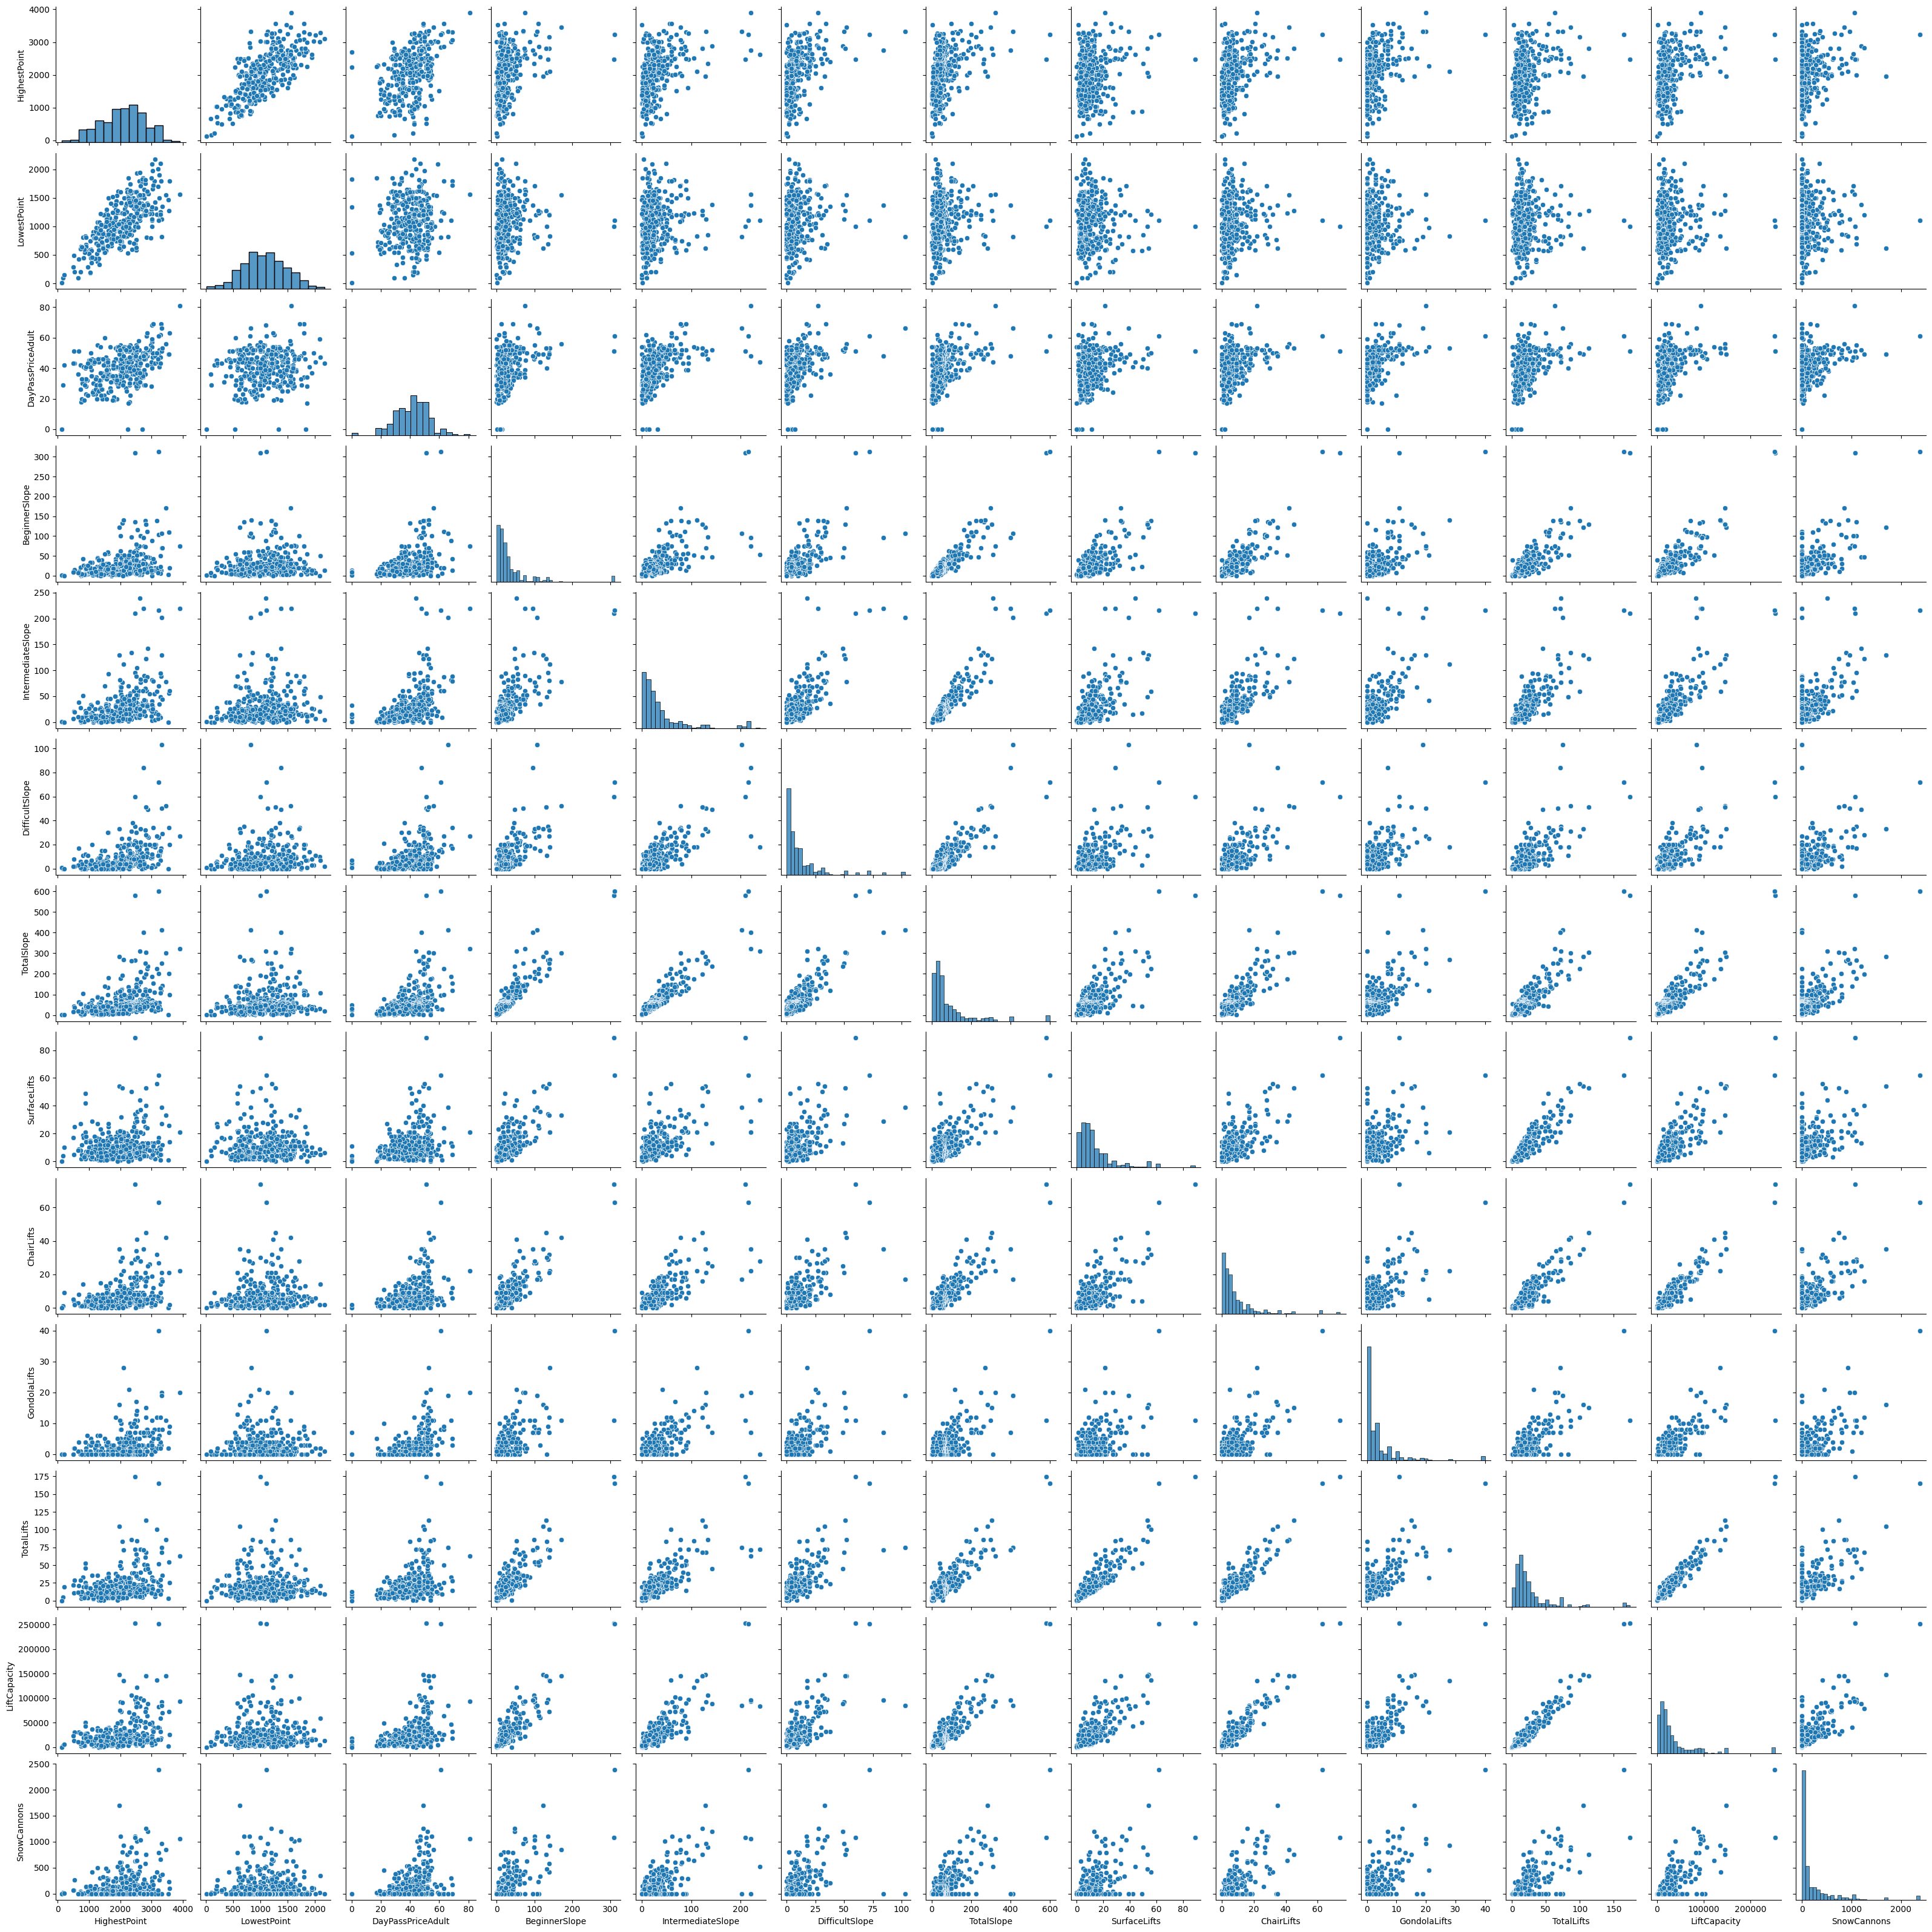

In [39]:
sns.pairplot(numericDF)


Another way to detect correlation is to calculate the Pearson correlation coefficient. We calculate the correlation matrix for the numerical data and visualize the matrix using a heatmap. 


In [40]:
corr_mat = numericDF.corr()

weak_positive_corr = set((col1, col2) for col1, col2 in combinations(corr_mat.columns, 2) if corr_mat.loc[col1, col2] > 0 and corr_mat.loc[col1, col2] < 0.3)
print('Number of column pairs with strong ')
print("WEAK POSITIVE CORRELATION:\n\n", weak_positive_corr)
print("\n----------------------------------------\n")

weak_negative_corr = set((col1, col2) for col1, col2 in combinations(corr_mat.columns, 2) if corr_mat.loc[col1, col2] < 0 and corr_mat.loc[col1, col2] > -0.3)
print("WEAK NEGATIVE CORRELATION:\n\n", weak_negative_corr)
print("\n----------------------------------------\n")

strong_positive_corr = set((col1, col2) for col1, col2 in combinations(corr_mat.columns, 2) if corr_mat.loc[col1, col2] >= 0.3 and corr_mat.loc[col1, col2] < 1)
print("STRONG POSITIVE CORRELATION:\n\n", strong_positive_corr)
print("\n----------------------------------------\n")

strong_negative_corr = set((col1, col2) for col1, col2 in combinations(corr_mat.columns, 2) if corr_mat.loc[col1, col2] <= -0.3 and corr_mat.loc[col1, col2] > -1)
print("STRONG NEGATIVE CORRELATION:\n\n", strong_negative_corr)

Number of column pairs with strong 
WEAK POSITIVE CORRELATION:

 {('HighestPoint', 'SurfaceLifts'), ('LowestPoint', 'LiftCapacity'), ('LowestPoint', 'DayPassPriceAdult'), ('LowestPoint', 'ChairLifts'), ('LowestPoint', 'IntermediateSlope'), ('LowestPoint', 'TotalLifts'), ('LowestPoint', 'DifficultSlope'), ('LowestPoint', 'SnowCannons'), ('LowestPoint', 'BeginnerSlope'), ('LowestPoint', 'TotalSlope')}

----------------------------------------

WEAK NEGATIVE CORRELATION:

 {('LowestPoint', 'SurfaceLifts'), ('LowestPoint', 'GondolaLifts')}

----------------------------------------

STRONG POSITIVE CORRELATION:

 {('SurfaceLifts', 'TotalLifts'), ('DayPassPriceAdult', 'DifficultSlope'), ('HighestPoint', 'TotalLifts'), ('SurfaceLifts', 'ChairLifts'), ('ChairLifts', 'SnowCannons'), ('IntermediateSlope', 'ChairLifts'), ('HighestPoint', 'ChairLifts'), ('DifficultSlope', 'ChairLifts'), ('GondolaLifts', 'SnowCannons'), ('DayPassPriceAdult', 'BeginnerSlope'), ('HighestPoint', 'LiftCapacity'), ('Hig

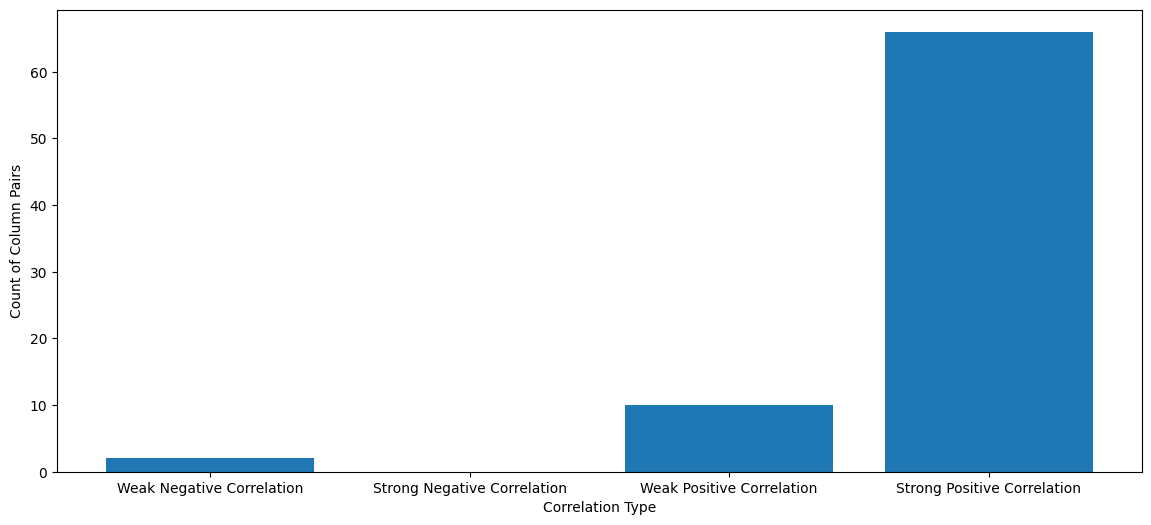

In [41]:
f, ax = plt.subplots(figsize=(14,6))
plt.bar(x=['Weak Negative Correlation', 'Strong Negative Correlation', 'Weak Positive Correlation', 'Strong Positive Correlation'],
        height=[len(weak_negative_corr), len(strong_negative_corr), len(weak_positive_corr), len(strong_positive_corr)])
plt.xlabel('Correlation Type')
plt.ylabel('Count of Column Pairs')
plt.show()

<Axes: >

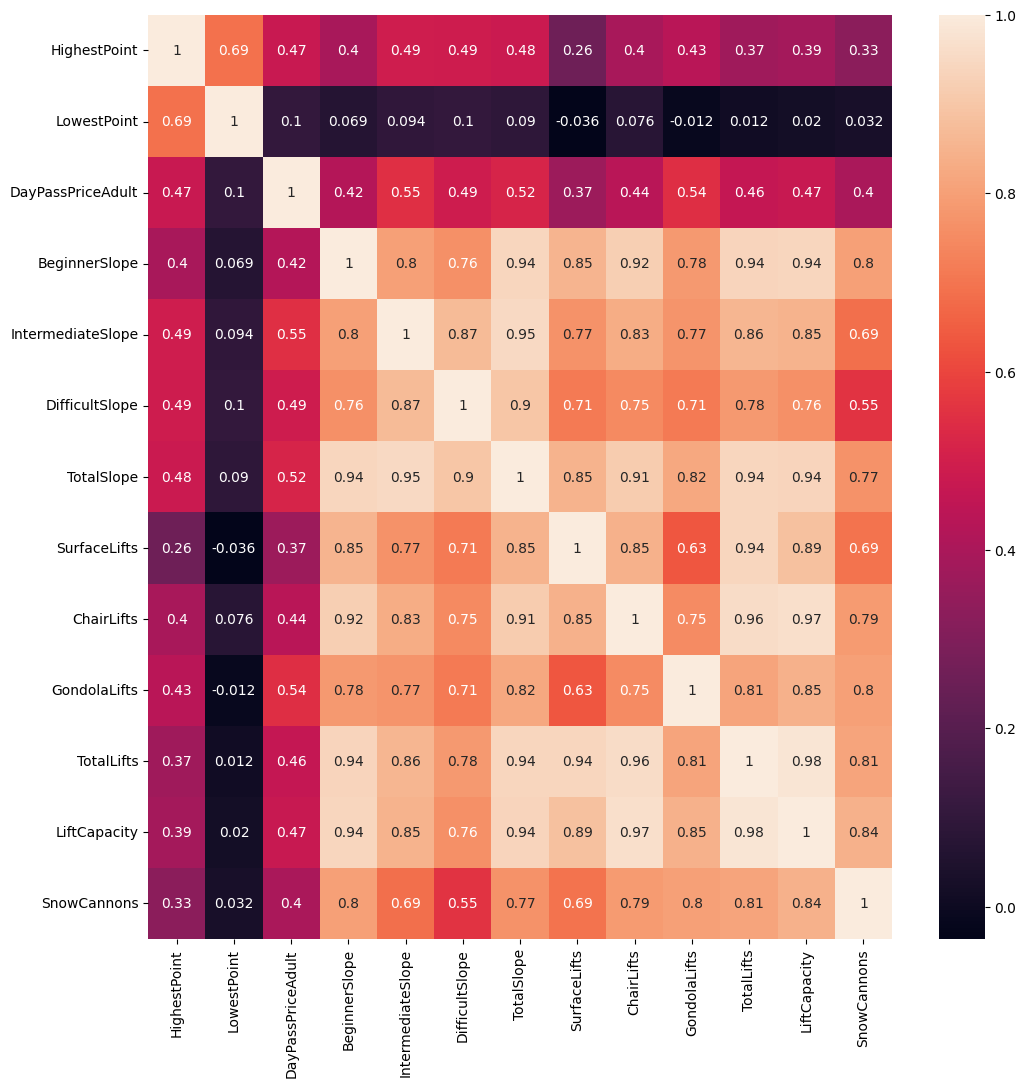

In [42]:
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_mat, annot = True)

<font color='green'>=> As seen in the barchart above, we can observe strong positive correlation in many of the column pairs. This could also be from the correlation heatmap. <br>
<br>
The same could also be observed in the pairplots. For a majority of column pairs, we see that the datapoint are closesly cluster around a positive-sloped regression line(if drawn). This indicates a strong positive correlation.
<br>
<br>
Furthermore, we did not observe any strong negative correlation amongst the features, however, there were a few feature pair with weak negative correlation and weak positive correlation.</font>

We now want to have an overview of the attribute "TotalSlope" aggregated by different levels of hierarchy (Europe -> Country -> Resort). It seems that a tree map is suitable for this purpose.

We make a tree map where
- the root node represents Europe.
- the child nodes of Europe are countries.
- the child nodes of each country are the ski resorts.
- the size of the rectangles is determined by the attribute "TotalSlope".

Also, we use the tree map to find out
1. The sum of TotalSlopes of a country, list the top five countries and the corresponding values.
2. The max value of TotalSlope of the five countries we identified in 1.



In [43]:
df_v.Country.unique()

array(['Austria', 'Andorra', 'Southern Russia', 'Poland', 'Bulgaria',
       'Bosnia and Herzegovina', 'Slovenia', 'France', 'Switzerland',
       'Germany', 'Spain', 'Italy', 'Sweden', 'Norway', 'Ukraine',
       'Finland', 'Serbia', 'Slovakia', 'Czech Republic', 'Romania',
       'Greece', 'United Kingdom', 'Liechtenstein', 'Lithuania',
       'Denmark', 'Netherlands'], dtype=object)

In [44]:
figure = px.treemap(df_v, path=[px.Constant("Europe"), 'Country', 'Resort'], values='TotalSlope')
figure.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



<font color='green'>=> From the treemap, `France` has the highest totalSlope count followed by `Austria`, `Switzerland`, `Italy` and `Andorra` as shown the table below: <br></font>

| Country | totalSlope |
| ------ | ----------- |
| France | 12546 |
| Austria | 7005 |
| Switzerland | 5710 |
| Italy | 3742  |
| Andorra | 723 |

In [45]:
#The above can also be seen here
groupedDF = df_v.groupby('Country')['TotalSlope'].sum().reset_index()
topFiveDF = groupedDF.sort_values('TotalSlope', ascending=False).head(5)
maxSlope = topFiveDF['TotalSlope'].max()
display(topFiveDF)
print('The max value of slope is: ', maxSlope)

,Country,TotalSlope
7,France,12546
1,Austria,7005
23,Switzerland,5710
10,Italy,3742
0,Andorra,723


The max value of slope is:  12546


<font color='green'>=> 1. The top five countries are `['France', 'Austria', 'Switzerland', 'Italy', 'Andorra']` in their respective orders and their totalSlope values is listed above.<br><br>2. The maximum value of `TotalSlope` is `12546` which is for `Country = France`</font>


An alternative to a tree map is a sunburst plot, the principle is similar to a tree map. 

- Each ring is a different level of the hierarchy
- Each segment of a ring belongs to one categorical value
- The size of a segment is either divided proportionally to a value

Now, we would like to have an overview of the attribute "TotalLifts" aggregated by different level of hierarchy.

Make a sunburst plot where
- the first hierarchy(ring) is "Country"
- the second hierarchy(ring) is "Snowparks" (whether the resort has snowparks)
- the third hierarchy(ring) is "Resort"
- the size of the segments is determined by the attribute "TotalLifts".


In [46]:
fig = px.sunburst(df_v, path=['Country', 'Snowparks', 'Resort'], values='TotalLifts')
fig.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/_plotly_utils/basevalidators.py:2596: DeprecationWarning:

*scattermapbox* is deprecated! Use *scattermap* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/




<font color='green'>=> In a sunburst plot, the size of the segment of proportional to the quantity(this case `TotalLifts`) of the category. The plot indicates that that `France` has the highest TotalLift sum, followed by `Austria`, `Switzerland`, `Italy` and others.
<br>
<br>
The next ring in each segment shows the presence of `Snowpark` at a resort in the Country and their size is determined `TotalLifts`. We can observe that in top 5 Countries a majority of resorts had snowparks.
<br>
<br>
In the last ring, we have the data of each individual resort and it's `TotalLifts` value and the size of segment is determined by `TotalLifts`.</font>

## Simpson's Paradox

### Sex Bias in Berkeley Graduate Admissions?

In the Fall of 1973, the University of California at Berkeley released data about their graduate class. The data showed the major the applicant applied to, their self-reported gender (Male or Female), and whether or not they were accepted or rejected. The acceptance rates between men and women were different. This caused immediate concern in the public as people thought that Berkeley was biased against women.

The "Berkeley Dataset" contains all 12,763 applicants to UC-Berkeley's graduate programs in Fall 1973. This dataset was published by UC-Berkeley researchers in an analysis to understand the possible gender bias in admissions.

Dataset Variables:

Year : number ➜ The application year (this value is always 1973)

Major : string ➜: An anonymized major code (either A, B, C, D, E, F, or Other). The specific majors are unknown except that A-F are the six majors with the most applicants in Fall 1973

Gender : string ➜ Applicant self-reported gender (either M or F)

Admission: string ➜ Admission decision (either Rejected or Accepted)

In [3]:
UCB_data = pd.read_csv('datasets/berkeley.csv')
UCB_data.head()

,Year,Major,Gender,Admission
0,1973,C,F,Rejected
1,1973,B,M,Accepted
2,1973,Other,F,Accepted
3,1973,Other,M,Accepted
4,1973,Other,M,Rejected


Remove the "Year" column as it does not contain any information in this dataset (all years are 1973.)

In [4]:
UCB_data = UCB_data.drop(['Year'], axis = 1)
UCB_data.head()

,Major,Gender,Admission
0,C,F,Rejected
1,B,M,Accepted
2,Other,F,Accepted
3,Other,M,Accepted
4,Other,M,Rejected


 For each of the values of column "Gender", we compute the admission rate and compare them against each other.

In [5]:
UCB_byGender = UCB_data.groupby('Gender').Admission.value_counts().to_frame(name = 'Count').reset_index()
UCB_byGender

,Gender,Admission,Count
0,F,Rejected,2827
1,F,Accepted,1494
2,M,Rejected,4704
3,M,Accepted,3738


In [6]:
total_female_applying = UCB_byGender.iloc[:2, -1].sum()
total_male_applying = UCB_byGender.iloc[2:4, -1].sum()
rate_female_admit = UCB_byGender.iloc[1, -1] / total_female_applying
rate_male_admit = UCB_byGender.iloc[3, -1] / total_male_applying

In [7]:
print('Total number of Females applying: ',total_female_applying)
print('Total number of Males applying: ',total_male_applying)
print('\nAdmission Rate for Females: ', rate_female_admit)
print('Admission Rate for Males: ', rate_male_admit)

Total number of Females applying:  4321
Total number of Males applying:  8442

Admission Rate for Females:  0.3457532978477204
Admission Rate for Males:  0.4427860696517413


<Axes: xlabel='Admission', ylabel='Count'>

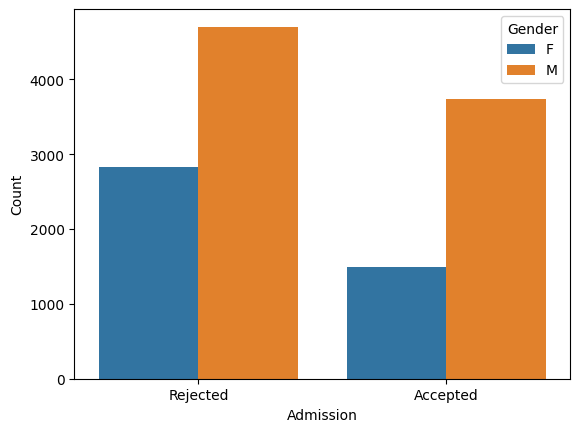

In [8]:
sns.barplot(data = UCB_byGender, x = 'Admission', y = 'Count', hue = 'Gender')

<font color='green'>=> From the data and illustration we can deduce that males had higher admission rates than females for Fall 73' semester. We should notice that the rejection rate of males is also higher than the rejection count of females since the number of males that have applied are also nearly double to that of females.</font>

 For each value combination of the "Gender" and "Major" columns, compute the admission rate. We compare the admission rate of women against the admission rate of men for each of the majors.

In [9]:
UCB_data["Admit"] = UCB_data.apply(lambda x: 1 if x["Admission"] == "Accepted" else 0, axis=1)
gen_admit_rates = UCB_data.groupby(["Major", "Gender"])["Admit"].mean()
gen_admit_rates = gen_admit_rates.reset_index()

In [10]:
gen_admit_rates

,Major,Gender,Admit
0,A,F,0.824074
1,A,M,0.724956
2,B,F,0.680000
3,B,M,0.630357
4,C,F,0.338954
5,C,M,0.369231
6,D,F,0.349333
7,D,M,0.330935
8,E,F,0.239186
9,E,M,0.277487


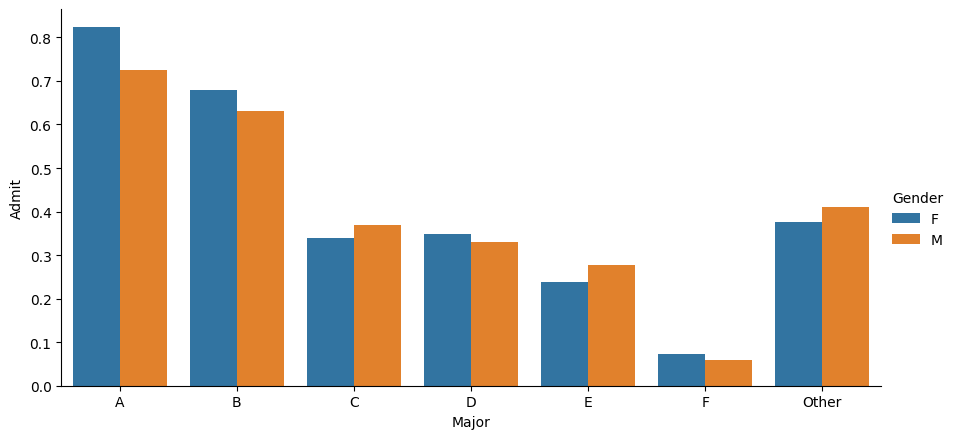

In [11]:
sns.catplot(x="Major", y="Admit", hue="Gender", kind="bar", data=gen_admit_rates, height=4.5, aspect=2)
plt.xlabel("Major")
plt.ylabel("Admit")
plt.show()

 Can we confirm there is a sex bias in the admission rates of the students?

<font color='green'>=> The graph above clearly indicates that there is no sex bias in the admission rates of student in UCB for Fall 73' semester. In the majors with most applicant i.e `A-F` as well as `Other` we see that the admit rate of women and men is fairly comparable and for each subject, the admission rate differs for male and female.</font>